In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
lotus = pd.read_csv("../data/230106_frozen_metadata.csv.gz", low_memory=False)
lotus = lotus.rename(columns={'organism_name': 'species', 'structure_smiles_2D': 'molecule'})

In [3]:
directory = '../out/'
dataframes = []  # List to hold dataframes
for filename in os.listdir(directory):
    if filename.endswith('.parquet'):  # Ensures only parquet files are read
        filepath = os.path.join(directory, filename)
        df = pd.read_parquet(filepath)  # Read parquet file to a pandas df
        dataframes.append(df)  # Append the df to the list
df = pd.concat(dataframes, ignore_index=True)

df.prob = df.prob.astype('float32')

In [4]:
pivot_df = df.pivot_table(index='species', columns='molecule', values='prob')
del df

In [5]:
from sklearn.preprocessing import StandardScaler
# Standardize the data (important for PCA)
scaler = StandardScaler()
species_std = scaler.fit_transform(pivot_df)

In [6]:
import umap

/usr/local/Caskroom/mambaforge/base/envs/stellargraph/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/Caskroom/mambaforge/base/envs/stellargraph/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/Caskroom/mambaforge/b

In [37]:
reducer = umap.UMAP(n_components=2,
                    n_neighbors=15,
                   min_dist=0.1)
embedding = reducer.fit_transform(species_std)

<Figure size 1000x500 with 0 Axes>

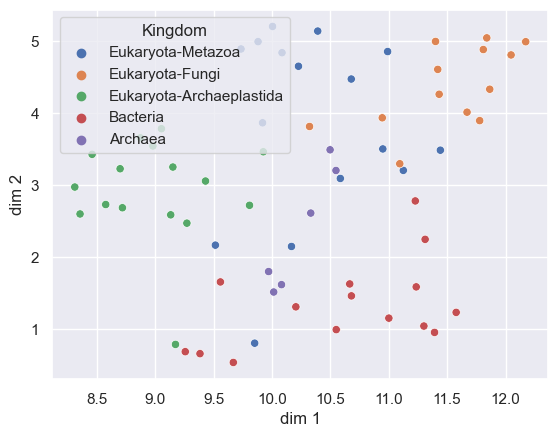

<Figure size 1000x500 with 0 Axes>

In [38]:
# Create a DataFrame from PCA results
embedding_df = pd.DataFrame(embedding, columns=['dim 1', 'dim 2'])
embedding_df['species'] = pivot_df.index  # Add species column from the index of pivot_df

# Merge the kingdom information into the PCA results dataframe
embedding_df = pd.merge(embedding_df, lotus[['species',
                                 'organism_taxonomy_02kingdom',
                                'organism_taxonomy_01domain']], on='species', how='left').drop_duplicates()
embedding_df['organism_taxonomy_02kingdom'] = embedding_df['organism_taxonomy_02kingdom'].fillna('Unknown')

embedding_df['Kingdom'] = embedding_df['organism_taxonomy_01domain'] + "-" + embedding_df['organism_taxonomy_02kingdom']
embedding_df.replace('Bacteria-Unknown', 'Bacteria', inplace=True)
embedding_df.replace('Archaea-Unknown', 'Archaea', inplace=True)

scatter = sns.scatterplot(data=embedding_df, x=embedding_df['dim 1'], y=embedding_df['dim 2'], hue='Kingdom')
plt.figure(figsize=(10, 5))